In [164]:
# Import required libraries
import pygetwindow as gw
import pyautogui
from PIL import Image
import numpy as np
from IPython.display import display
from ipywidgets import Output
from IPython.display import clear_output


In [165]:
# Find the Bejeweled 3 window and get its position and size
window_title = 'Bejeweled 3'
window = None
for w in gw.getAllWindows():
    if window_title.lower() in w.title.lower():
        window = w
        break
if window is None:
    raise Exception(f'Window titled "{window_title}" not found!')
left, top, width, height = window.left, window.top, window.width, window.height
print(f'Window position: ({left}, {top}), size: ({width}x{height})')

Window position: (-7, 0), size: (816x639)


In [166]:
left += 270  # Adjust for window border
top += 70 # Adjust for window title bar
# Define the region to capture the game area
width -= 310  # Adjust for window border
height -= 130  # Adjust for window title bar and bottom border

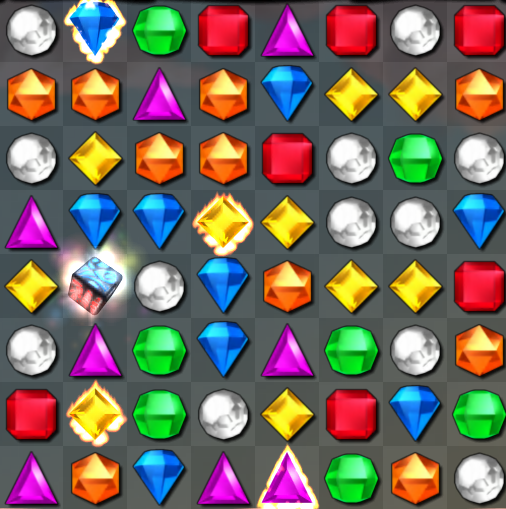

In [167]:
# Take a screenshot of the Bejeweled 3 window region
screenshot = pyautogui.screenshot(region=(left, top, width, height))
display(screenshot)


In [168]:
from collections import defaultdict
import numpy as np

grid_width = 64
grid_height = 64
grid_columns = 8
grid_rows = 8

import colorsys

def adjust_to_color_bucket(color):
    r, g, b = [x / 255.0 for x in color]
    h, s, v = colorsys.rgb_to_hsv(r, g, b)

    # Group as yellow if hue is in yellow range, even if saturation is low
    if 0.15 <= h <= 0.18 and v >= 0.8:
        return (255, 240, 0)  # Unified yellow bucket

    return (round(r * 255), round(g * 255), round(b * 255))


def avg_color(pixels):
    # Calculate the average for each channel
    arr = np.array(pixels)
    return tuple(int(arr[:, i].mean()) for i in range(3))

def gather_game_grid(screenshot, grid_width, grid_height, grid_columns, grid_rows):
    game = list()    
    # add a dot at the center of each grid cell
    for row in range(grid_rows):
        _rowArray = list()
        for col in range(grid_columns):
            x_center = col * grid_width + grid_width // 2
            y_center = row * grid_height + grid_height // 2
            # Collect a 3x3 grid of pixels around the center
            pixels = []
            for dx in range(-2, 3):
                for dy in range(-2, 3):
                    x = x_center + dx
                    y = y_center + dy
                    if 0 <= x < screenshot.width and 0 <= y < screenshot.height:
                        pixels.append(screenshot.getpixel((x, y)))
            if pixels:
                color = adjust_to_color_bucket(avg_color(pixels))
            else:
                color = (0, 0, 0)
            _rowArray.append(color)
        game.append(_rowArray)
            
    return game
game_grid = gather_game_grid(screenshot, grid_width, grid_height, grid_columns, grid_rows)
game_grid


[[(231, 231, 231),
  (12, 121, 240),
  (16, 161, 35),
  (246, 23, 51),
  (236, 11, 237),
  (246, 23, 51),
  (231, 231, 231),
  (246, 23, 51)],
 [(223, 101, 32),
  (223, 101, 32),
  (236, 11, 237),
  (223, 101, 32),
  (14, 127, 246),
  (255, 240, 0),
  (255, 240, 0),
  (223, 101, 32)],
 [(231, 231, 231),
  (255, 240, 0),
  (223, 101, 32),
  (223, 101, 32),
  (246, 23, 51),
  (231, 231, 231),
  (16, 161, 35),
  (231, 231, 231)],
 [(236, 11, 237),
  (14, 127, 246),
  (14, 127, 246),
  (255, 240, 0),
  (255, 240, 0),
  (231, 231, 231),
  (231, 231, 231),
  (14, 127, 246)],
 [(255, 240, 0),
  (93, 125, 157),
  (231, 231, 231),
  (14, 127, 246),
  (223, 101, 32),
  (255, 240, 0),
  (255, 240, 0),
  (246, 23, 51)],
 [(231, 231, 231),
  (236, 11, 237),
  (16, 161, 35),
  (14, 127, 246),
  (236, 11, 237),
  (16, 161, 35),
  (231, 231, 231),
  (223, 101, 32)],
 [(246, 23, 51),
  (255, 240, 0),
  (16, 161, 35),
  (231, 231, 231),
  (255, 240, 0),
  (246, 23, 51),
  (14, 127, 246),
  (16, 161, 35)

In [169]:
from colorsys import rgb_to_hsv

def debug_hsv(rgb):
    r, g, b = [x / 255.0 for x in rgb]
    h, s, v = rgb_to_hsv(r, g, b)
    return h, s, v

for c in [(252, 242, 33), (255, 255, 205), (255, 254, 134)]:
    print(c, debug_hsv(c))

(252, 242, 33) (0.15905631659056316, 0.8690476190476191, 0.9882352941176471)
(255, 255, 205) (0.16666666666666666, 0.196078431372549, 1.0)
(255, 254, 134) (0.1652892561983471, 0.4745098039215686, 1.0)


In [170]:
from IPython.display import display, HTML

def show_color_grid(game_grid):
    html = '<table style="border-collapse:collapse;">'
    for row in game_grid:
        html += '<tr>'
        for color in row:
            rgb = f'rgb{color}'
            html += f'<td style="width:32px;height:32px;background:{rgb};border:1px solid #333;">{rgb}</td>'
        html += '</tr>'
    html += '</table>'
    display(HTML(html))




In [171]:
import time

def colors_match(c1, c2, tolerance=30):
    return all(abs(a - b) < tolerance for a, b in zip(c1, c2))

def count_match(grid, r, c):
    color = grid[r][c]
    # Horizontal
    count_h = 1
    for dc in [-1, 1]:
        cc = c + dc
        while 0 <= cc < len(grid[0]) and colors_match(grid[r][cc], color):
            count_h += 1
            cc += dc
    # Vertical
    count_v = 1
    for dr in [-1, 1]:
        rr = r + dr
        while 0 <= rr < len(grid) and colors_match(grid[rr][c], color):
            count_v += 1
            rr += dr
    return max(count_h if count_h >= 3 else 0, count_v if count_v >= 3 else 0)

def find_best_move(grid):
    rows, cols = len(grid), len(grid[0])
    best_score = 0
    best_move = None
    for r in range(rows-1, -1, -1):
        for c in range(cols-1, -1, -1):
            # Try horizontal swap
            if c < cols - 1:
                grid[r][c], grid[r][c+1] = grid[r][c+1], grid[r][c]
                score = count_match(grid, r, c) + count_match(grid, r, c+1)
                if score > best_score:
                    best_score = score
                    best_move = ((r, c), (r, c+1))
                grid[r][c], grid[r][c+1] = grid[r][c+1], grid[r][c]
            # Try vertical swap
            if r < rows - 1:
                grid[r][c], grid[r+1][c] = grid[r+1][c], grid[r][c]
                score = count_match(grid, r, c) + count_match(grid, r+1, c)
                if score > best_score:
                    best_score = score
                    best_move = ((r, c), (r+1, c))
                grid[r][c], grid[r+1][c] = grid[r+1][c], grid[r][c]
    return best_move, best_score

def check_match(grid, r, c):
    color = grid[r][c]
    # Horizontal
    count = 1
    for dc in [-1, 1]:
        cc = c + dc
        while 0 <= cc < len(grid[0]) and colors_match(grid[r][cc], color):
            count += 1
            cc += dc
    if count >= 3:
        return True
    # Vertical
    count = 1
    for dr in [-1, 1]:
        rr = r + dr
        while 0 <= rr < len(grid) and colors_match(grid[rr][c], color):
            count += 1
            rr += dr
    return count >= 3

def grid_to_screen(row, col):
    x = left + col * grid_width + grid_width // 2
    y = top + row * grid_height + grid_height // 2
    return x, y


In [172]:
def get_mouse_position():
    """Get the current mouse position."""
    return pyautogui.position()
last_mouse_position = (None, None)
def click_at(x, y):
    """Click at the specified screen coordinates."""
    global last_mouse_position
    current_pos = pyautogui.position()
    if last_mouse_position != (None, None) and current_pos != last_mouse_position:
        print(f"Mouse position has changed from {last_mouse_position} to {current_pos}. Stopping bot.")
        raise ValueError("Mouse position has changed since last click. Stopping bot.")
    
    last_mouse_position = (x, y)
    pyautogui.click(x=x, y=y)

In [173]:
def screen_position_to_screenshot_position(x, y):
    """Convert screen coordinates to screenshot coordinates."""
    return x - left, y - top

In [174]:
def close_color(rgb,rgb2,tolerance=30):
    """Check if two colors are close enough to be considered the same."""
    return all(abs(a - b) < tolerance for a, b in zip(rgb, rgb2))
 

In [175]:
def is_in_rankup_menu(screenshot):
    
    correct_color = (126, 2, 77)
    pos = (479, 150)
    color = screenshot.getpixel(screen_position_to_screenshot_position(*pos))
    return (close_color(correct_color,color))


def is_in_badges(screenshot):
    correct_color = (159, 33, 111)
    pos = (531, 75)
    color = screenshot.getpixel(screen_position_to_screenshot_position(*pos))
    return (close_color(correct_color,color))



def is_in_unlock_menu(screenshot):
    correct_color = (181, 54, 133)
    pos = (563, 199)
    color = screenshot.getpixel(screen_position_to_screenshot_position(*pos))
 
    return (close_color(correct_color,color))
is_in_badges(screenshot)


False

In [ ]:
def screenshot_diff(screenshot1, screenshot2):
    """Calculate the difference between two screenshots."""
    arr1 = np.array(screenshot1)
    arr2 = np.array(screenshot2)
    diff = np.abs(arr1 - arr2)
    return np.mean(diff)
def display_diff(diff):
    """Display the difference as an image."""
    diff_image = Image.fromarray(np.uint8(diff))
    display(diff_image)

In [ ]:
shared_output = Output()
display(shared_output)
time.sleep(5)  # Allow time for the display to render
last_mouse_position = (None, None)
old_screenshot = None
while True:
    screenshot = pyautogui.screenshot(region=(left, top, width, height))
    difference = screenshot_diff(screenshot, old_screenshot) if old_screenshot else None
    game_grid = gather_game_grid(screenshot, grid_width, grid_height, grid_columns, grid_rows)

    with shared_output:
        clear_output()
        show_color_grid(game_grid)
        display_diff(difference) if difference is not None else None
    best_move, best_score = find_best_move(game_grid)
    if is_in_rankup_menu(screenshot):
        click_at(x=404, y=383)
    elif is_in_badges(screenshot):
        
        click_at(x=403, y=560)
    elif is_in_unlock_menu(screenshot):
        click_at(x=404, y=383)
    else:
        #print(best_move)
        if best_move:
            (r1, c1), (r2, c2) = best_move
            x1, y1 = grid_to_screen(r1, c1)
            x2, y2 = grid_to_screen(r2, c2)
            
            with shared_output:
                print(f"Swapping ({r1},{c1}) <-> ({r2},{c2}) at screen ({x1},{y1}) <-> ({x2},{y2}) with score {best_score}")
            click_at(x=x1, y=y1)
            time.sleep(0.1)
            click_at(x=x2, y=y2)
        else:
            print("No valid move found.")
    old_screenshot = screenshot
    time.sleep(1)  # Sleep to avoid busy waiting

Output()

No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


No valid move found.


KeyboardInterrupt: 

In [ ]:
time.sleep(1)  # Allow time for the game to update
pos =get_mouse_position()
color = screenshot.getpixel(screen_position_to_screenshot_position(*pos))
print(f"Mouse position: {pos}, Color: {color}")

